# GBA 6430 - Big Data Technology in Business
# Dr. Mohammad Salehan
# Graph Mining Assignment
In this assignment, you will analyze Reddit Hyperlink Network. The hyperlink network represents the directed connections between two subreddits (a subreddit is a community on Reddit). The network is extracted from publicly available Reddit data of 2.5 years from Jan 2014 to April 2017.
<a href='https://snap.stanford.edu/data/soc-RedditHyperlinks.html'> link to dataset source and description</a>  
<u>In each step, you need to use at least one graph-specific operation. If your solution for any step uses dataframe operations only, you will only receive 50% of the credit for that step.</u>

In [18]:
# Note, ensure you have already installed the GraphFrames spark-package
from graphframes import *
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import pyspark.sql.functions as F
ps.set_option('plotting.backend', 'matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Building the Graph
Below we load the dataset which contains a list of links between subreddits.

In [2]:
%%pretty
data = ps.read_csv('s3://cis4567-data/reddit/', sep='\t')
print(data.shape)
data.to_spark().show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.756..."


In [3]:
data.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'POST_ID', 'TIMESTAMP',
       'LINK_SENTIMENT', 'PROPERTIES'],
      dtype='object')

The nodes dataframe is simply a list of unique subreddits.

In [4]:
%%pretty
nodes = ps.concat(
    [data['SOURCE_SUBREDDIT'].unique(), 
     data['TARGET_SUBREDDIT'].unique()]).to_frame('id').drop_duplicates().reset_index(drop=True)
nodes.to_spark().show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id
0131
07scape
0x10c
0x3642
100daycomicchallenge


Create a graph object using nodes and vertices.

In [15]:
g = GraphFrame(nodes.to_spark(), 
               data.rename({'SOURCE_SUBREDDIT':'src',
                           'TARGET_SUBREDDIT': 'dst'}, axis=1).to_spark())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Assignment steps
1- Calculate the unique number of subreddits and the number of links in dataset.

In [6]:
print("unique number of subreddits: %d" % g.vertices.count())
print("number of link: %d" % g.edges.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

unique number of subreddits: 35776
number of link: 286561

2- Identify the top 10 subreddits by the number of inward links.

In [7]:
%%pretty
SUBREDDIT_degree = g.outDegrees.pandas_api().rename(columns={"id": "oId"})
full_SUBREDDIT_degree = ps.merge(SUBREDDIT_degree, g.vertices.pandas_api(),
                                    left_on="oId", right_on="id"
                                   ).sort_values("outDegree", ascending=False
                                                )[["id", "outDegree"]]
full_SUBREDDIT_degree.to_spark().show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id,outDegree
subredditdrama,4665
circlebroke,2358
shitliberalssay,1968
outoftheloop,1958
copypasta,1824
writingprompts,1707
hailcorporate,1560
circlejerkcopypasta,1517
conspiracy,1462
bestofoutrageculture,1354


3- Using `Page Rank`, find the top 10 most popular subreddits.

In [8]:
ranks = g.pageRank(resetProbability=0.15, maxIter=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

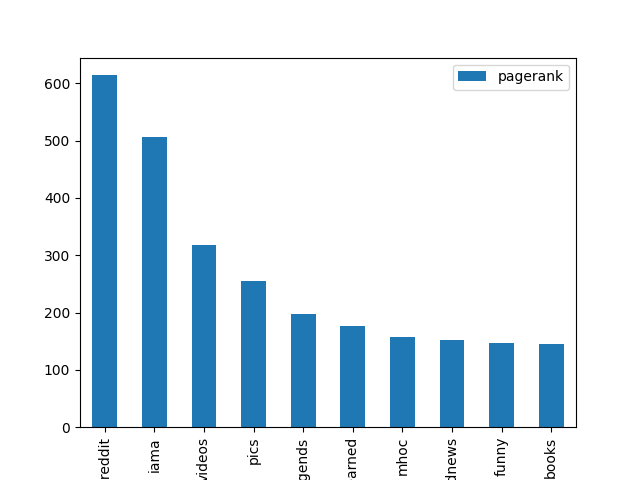

In [9]:
#plot top 10 airports
df = ranks.vertices.pandas_api().sort_values("pagerank", ascending=False).iloc[:10]
df.plot(x='id', y='pagerank', kind='bar')
#plt.show()
%matplot plt

4- How is the `Page Rank` output different from what you found in step 2?

PageRank is a “vote”, by all the other pages on the Web, about how important a page is. A link to a page counts as a vote of support. Hence, at each step, the random walk might restart randomly using the reset probability value (epsilon ε).
For PageRank, askreddit, iama, and videos has high PageRank scores because they are likely to be connected to other important subreddits.
For Degree Centrality, subredditdrama and circlebroke might actively link to many other subreddits, resulting in high out-degree centrality, but they might not necessarily receive as many important inbound links.

5- Some users go down a rabbit hole and end up in radical subreddits. Using motifs, find the top 10 subreddits that act as intermediary to get users to `4chan` subreddit.

In [23]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)").filter("c.id = '4chan'"))
result = (motifs.groupBy("b.id").count().withColumnRenamed("count", "intermediary_count")
          .sort(F.desc("intermediary_count")).limit(10))
result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------------+
|            id|intermediary_count|
+--------------+------------------+
|     askreddit|             21987|
|  outoftheloop|             19090|
|    the_donald|              6240|
|subredditdrama|              5265|
|          iama|              3694|
|     copypasta|              2812|
|writingprompts|              2490|
|         anime|              1942|
|      dogecoin|              1800|
|         drama|              1345|
+--------------+------------------+

6- Find the shortest path from `disney` to `4chan`.

In [26]:
%%pretty
filteredPaths = g.bfs(
  fromExpr="id = 'disney'",
  toExpr="id = '4chan'",
  maxPathLength=2)
filteredPaths.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

from,e0,v1,e1,to
{disney},"{disney, writingp...",{writingprompts},"{writingprompts, ...",{4chan}
{disney},"{disney, iama, 3o...",{iama},"{iama, 4chan, 3rn...",{4chan}
{disney},"{disney, anime, 5...",{anime},"{anime, 4chan, 2g...",{4chan}
{disney},"{disney, anime, 5...",{anime},"{anime, 4chan, 3z...",{4chan}
